# Understanding precipitation variability under climate change

This notebook creates a figure of precip changes (both mean and variability) as a function of GMST. It essentially replicates Figure 3 in [this paper](https://www.nature.com/articles/s41598-017-17966-y). It was a product of the NCAR CMIP6 Hackathon Oct 16-18, 2019.

Authors:
- Angeline Pendergrass, NCAR
- Chiara Lepore, LDEO
- Kevin Schwarzwald, Columbia Univ.
- Ian Bolliger, UC Berkeley

Currently, this is designed to work using the environment specified in the `environment.yml` file contained in this repo, on either the NCAR supercomputing infrastructure or on [ocean.pangeo.io](ocean.pangeo.io)

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
# import gcsfs
from tqdm.autonotebook import tqdm
from scipy import signal
import util

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [8]:
# Experiments to process
experiment_ids = ['historical', 'ssp370']

# Seasons to process
seasons = ['all','DJF','JJA']

# total time range of assets we would need
time_range = [1976, 2100]

# Time slices (future) to process
time_slices = ([['1991','2020'],
                ['2001','2030'],
                ['2011','2040'],
                ['2021','2050'],
                ['2031','2060'],
                ['2041','2070'],
                ['2051','2080'],
                ['2061','2090'],
                ['2071','2100']])

# variables we need to aggregate
# There is no huss on the cloud! abandon for now
# variable_ids = ['pr','tas','huss']
variable_ids = ['pr','tas']



# tables needed
table_ids = ['Amon']

# temporally constant vars needed for aggregation
const_vars = ['sftlf','areacella']

## Finding data

First, we get a list of all the data assets we will need to read in for this analysis.

In [9]:
col = util.load_data_catalog()

In [10]:
# subset to overall things we're looking at
subset = col.search(experiment_id=experiment_ids, 
                    variable_id=variable_ids,
                    table_id=table_ids)

In [11]:
# subset to models that have all the variables we want
# (monthly tas, pr, huss) for both historical and ssp370
uni_dict = subset.unique(['source_id','table_id','variable_id'])
models = set(uni_dict['source_id']['values']) # all the models
for v in variable_ids:
    for e in experiment_ids:
        cat = subset.search(variable_id=v, experiment_id=e)
        models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

models = list(models)

# subset to relevant models
col_vars = subset.search(source_id=models)

In [14]:
if util.is_ncar_host():
        ## subset on years
    model_df = col_vars.df.copy()

    # clean up dates
    years = model_df.time_range.str.split('-', expand=True).apply(lambda ser: ser.str[:4]).astype(int)

    # subset
    valid = ((years[0]>= time_range[0]) & (years[0] <= time_range[1]) | 
             (years[1]>= time_range[0]) & (years[1] <= time_range[1]))

    # return to our collection
    col_vars.df = model_df[valid]

In [15]:
## get all the appropriate constant assets

# subset full collection to models we're using
models = col_vars.unique('source_id')['source_id']['values']
subset_const = col.search(source_id=models, variable_id=const_vars)

# subset to models that have all the variables we want
# (monthly tas, pr, huss)
uni_dict = subset_const.unique(['source_id','variable_id'])
models_const = set(uni_dict['source_id']['values']) # all the models
for v in const_vars:
    cat = col.search(variable_id=v)
    models_const = models_const.intersection({model for model in cat.df.source_id.unique().tolist()})

models = list(models_const)

# subset to relevant models
col_const = subset_const.search(source_id=models)

Finding fixed grid assets to use for our models. **NOTE (IB, 10/17/19)**: For now, I'm assuming that any grid with the same `grid_label` and `source_id` will be the same. Hopefully this is true. This is to avoid the complicated fuzzy matching algorithm needed to deal with the varied ways in which modeling groups save `fx` tables.

In [16]:
single_const_df = col_const.df.copy().groupby(['source_id','grid_label','variable_id']).first().reset_index()
col_const.df = single_const_df

**NOTE (IB, 10/17/19)**: Here I am subsetting to only the models that have `areacella` and `sftlf`. I'm hoping that we'll have that data at some point for all models, so am not going through the logistical challenge of calculating these values for models that don't have them. If we need to, we can do that at some point

In [17]:
col_vars = col_vars.search(source_id=models)

Now, back to our regularly scheduled programming...

First, load dask cluster to deal with large data

In [18]:
#if util.is_ncar_host():
#    from ncar_jobqueue import NCARCluster
#    cluster = NCARCluster(project='UCGD0006')
#    cluster.adapt(minimum_jobs=1, maximum_jobs=10)
#else:
#    from dask_kubernetes import KubeCluster
#    cluster = KubeCluster()
#    cluster.adapt(minimum=1, maximum=10)
#cluster

In [19]:
#from dask.distributed import Client
#client = Client(cluster) # Connect this local process to remote workers
#client

Here's where everything started breaking... I thought it was a memory issue, but dask didn't help. I think it's a bug in `intake-esm` (see my slack note) -IB

In [20]:
modelname=models[0]
varname='tas'
expt_id='ssp370'

In [21]:
col_var_exp_mod = col_vars.search(variable_id=varname).search(source_id=modelname).search(experiment_id=expt_id)
dict_var_exp_mod=col_var_exp_mod.to_dataset_dict()
dict_var_exp_mod[list(dict_var_exp_mod)[0]]

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, member_id: 2, nbnd: 2, time: 1032)
Coordinates:
  * time       (time) object 2015-01-15 12:00:00 ... 2100-12-15 12:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U8 'r1i1p1f1' 'r2i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    time_bnds  (time, nbnd) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 817, 192, 288), meta=np.ndarray>
Attributes:
    parent_activity_id:     CMIP
    branch_method:          standard
    variant_info:           CMIP6 SSP3-7.0 experiments (2015-2100) with CAM6,...
    grid:                   native 0.9x1.2

In [22]:
thisds=dict_var_exp_mod[list(dict_var_exp_mod)[0]]

In [23]:
thisds.member_id[0].item(0)

'r1i1p1f1'

In [24]:
thisds.member_id.shape[0]

2

In [25]:
thisds.sel(member_id='r1i1p1f1')


<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 1032)
Coordinates:
  * time       (time) object 2015-01-15 12:00:00 ... 2100-12-15 12:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member_id  <U8 'r1i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    time_bnds  (time, nbnd) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(817, 192, 288), meta=np.ndarray>
Attributes:
    parent_activity_id:     CMIP
    branch_method:          standard
    variant_info:           CMIP6 SSP3-7.0 experiments (2015-2100) with CAM6,...
    grid:                   native 0.9x1.25 finite volume grid (192x288 latxlon)
    model_do

In [26]:
### NEW load data function
# Function to load data: df_data has the catalogue of the variable of interest
def load_data(col_vars, varname, modelname, expt_id):
    """
    Load data for given variable, source and expt ids.
    """
    col_var_exp_mod = col_vars.search(variable_id=varname).search(source_id=modelname).search(experiment_id=expt_id)
    dict_var_exp_mod=col_var_exp_mod.to_dataset_dict()
    ds_allvariants = dict_var_exp_mod[list(dict_var_exp_mod)[0]]
    # for consistency with existing code, restrict to just one variant for now
#    thisds.member_id[0].item(0)
    thisds = dict_var_exp_mod[list(dict_var_exp_mod)[0]]
    firstvariantlabel = thisds.member_id[0].item(0)
    ds = thisds.sel(member_id=firstvariantlabel)
    return ds


load data provies a Dataset. 
ds.var is a DataArray. 
note that it doesn't have a member_id because that got excluded early on

In [27]:
# Function to get mean and variability and their changes
def mean_dtas_calc(data_tmp,seas='all', weights_in=None):
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    
        
    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .tas.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .tas.mean('time'))
    if weights_in is not None:
        weights = weights_in.areacella
        mu_histG = np.average(mu_hist,weights=weights)
        mu_futrG = np.average(mu_futr,weights=weights)
    else:
        # Area weighting
        latr = np.deg2rad(data_tmp['hist'].lat)
        # Use the cosine of the converted latitudes as weights for the average
        weights = np.cos(latr)
        mu_histG = np.average(mu_hist.mean("lon"),weights=weights)
        mu_futrG = np.average(mu_futr.mean("lon"),weights=weights)
        
    dtasG = mu_futrG-mu_histG
#    dmu = mu_futr/mu_hist
#    dmuG = np.average(dmu.mean("lon"),weights=weights.values)

    # Out 
    outp = xr.Dataset(
        data_vars = {#'tas_hist': tas_hist,
                     #'tas_futr': tas_futr,
                     #'dmu':     dmu,
                     'dtasG':    ([],dtasG)}

        #coords={'lon':            (['lon'],results_tmp['hist'].lon),
        #        'lat':             (['lat'],results_tmp['hist'].lat)}
        )


    return(outp)

In [28]:

tdata = {}
tresults = {}

for mod_name in tqdm(models):
    # get a 20 year period
    # try:
        print('\n\nStarting '+mod_name+'\n')
        # def load_data(col_vars, varname, modelname, expt_id):
        ds_hist = load_data(col_vars, 'tas', mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
        ds_ssp  = load_data(col_vars, 'tas', mod_name, experiment_ids[1])
        
        try: # try getting areacella data
            ds_areacella = load_data(col_vars, 'areacella', mod_name, experiment_ids[0])

        except: #if not available, flag it as 0. It will use np.cos(lat)
            ds_areacella = None
        
        tdata[mod_name] = {}
        tresults[mod_name] = {}
        
        for time_slice in time_slices:
            print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
            if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
                print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
                break
            
            # Get corresponding temporal slice of data and stage it
            ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
            tdata[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}
            
            
            tresults[mod_name]["t"+time_slice[0]] = {}
           # Calculate means, sds,...
            tresults[mod_name]['t'+time_slice[0]] = mean_dtas_calc(tdata[mod_name]['t'+time_slice[0]],
                                                                   seas = 'all', weights_in=ds_areacella)
            print(' processed!')
                
            print(time_slice[0]+'-'+time_slice[1]+' processed!')
            
        print(mod_name+' processed!')
    #except:
    #    print(mod_name+"broken")



Starting CESM2

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 0 group(s)
Begin processing time slice 1991-2020
 processed!
1991-2020 processed!
Begin processing time slice 2001-2030
 processed!
2001-2030 processed!
Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
 processed!
2031-2060 processed!
Begin processing time slice 2041-2070
 processed!
2041-2070 processed!
Begi

KeyboardInterrupt: 

In [29]:
pd.DataFrame(tresults)

,CESM2,CNRM-CM6-1,CESM2-WACCM
t1991,[dtasG],[dtasG],[dtasG]
t2001,[dtasG],[dtasG],[dtasG]
t2011,[dtasG],[dtasG],[dtasG]
t2021,[dtasG],[dtasG],[dtasG]
t2031,[dtasG],[dtasG],[dtasG]
t2041,[dtasG],[dtasG],[dtasG]
t2051,[dtasG],[dtasG],[dtasG]
t2061,[dtasG],[dtasG],[dtasG]
t2071,[dtasG],[dtasG],[dtasG]


In [30]:
tresults_new=tresults
for model in tresults:
    for timeperiod in tresults[model]:
        tresults_new[model][timeperiod]=tresults_new[model][timeperiod].dtasG.values.item(0)


In [31]:
tresults_new

{'CESM2': {'t1991': 0.6872858319906072,
  't2001': 0.8865586255939206,
  't2011': 1.0634387442217417,
  't2021': 1.306641916298986,
  't2031': 1.6259899682397645,
  't2041': 1.9963961107961268,
  't2051': 2.454072430827864,
  't2061': 2.9941796871869997,
  't2071': 3.510043154912637},
 'CNRM-CM6-1': {'t1991': 0.5663899794195686,
  't2001': 0.7143872019087212,
  't2011': 0.84538051203333,
  't2021': 1.1228811931093219,
  't2031': 1.509964857607656,
  't2041': 1.95690503396861,
  't2051': 2.4652402217174654,
  't2061': 3.018977081211176,
  't2071': 3.6157809308425612},
 'CESM2-WACCM': {'t1991': 0.7680837169939991,
  't2001': 0.8773877670349748,
  't2011': 1.0078035958820806,
  't2021': 1.271294305239337,
  't2031': 1.6422187372364192,
  't2041': 2.0986051826466223,
  't2051': 2.548464202198943,
  't2061': 3.027118428956669,
  't2071': 3.494716183223602}}

In [32]:
if util.is_ncar_host():
    pd.DataFrame(tresults_new).to_csv('tresults_intake-esm-cheyenne.csv')
else:
    pd.DataFrame(tresults_new).to_csv('tresults_intake-esm-cloud.csv')

In [33]:
if util.is_ncar_host():
    tresults_new=pd.read_csv('tresults_intake-esm-cheyenne.csv',index_col=0)
else:
    tresults_new=pd.read_csv('tresults_intake-esm-cloud.csv',index_col=0)
    
tresults_new

,CESM2,CNRM-CM6-1,CESM2-WACCM
t1991,0.687286,0.566390,0.768084
t2001,0.886559,0.714387,0.877388
t2011,1.063439,0.845381,1.007804
t2021,1.306642,1.122881,1.271294
t2031,1.625990,1.509965,1.642219
t2041,1.996396,1.956905,2.098605
t2051,2.454072,2.465240,2.548464
t2061,2.994180,3.018977,3.027118
t2071,3.510043,3.615781,3.494716


In [34]:
tresults_dict=tresults_new.to_dict()

In [35]:
dt=np.zeros((len(time_slices),len(tresults_dict)))*np.nan 

In [36]:
modelcount=0
modelnames=[]
for model in tresults_dict:
    modelnames.append(model)
    timecount=0
    for timeperiod in tresults_dict[model]:
        dt[timecount,modelcount]=tresults_dict[model][timeperiod]
        timecount=timecount+1
    modelcount=modelcount+1

In [37]:
dt

array([[0.68728583, 0.56638998, 0.76808372],
       [0.88655863, 0.7143872 , 0.87738777],
       [1.06343874, 0.84538051, 1.0078036 ],
       [1.30664192, 1.12288119, 1.27129431],
       [1.62598997, 1.50996486, 1.64221874],
       [1.99639611, 1.95690503, 2.09860518],
       [2.45407243, 2.46524022, 2.5484642 ],
       [2.99417969, 3.01897708, 3.02711843],
       [3.51004315, 3.61578093, 3.49471618]])

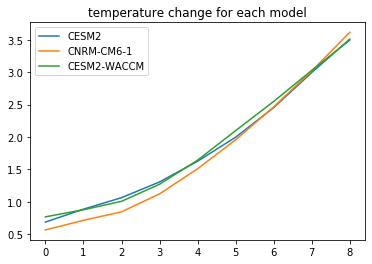

In [38]:
plt.plot(dt)
plt.title('temperature change for each model')
plt.legend(modelnames)

In [39]:
# Function to get mean and variability and their changes
def mean_var_calc(data_tmp,seas='all',weights_in=None):
    print(weights_in)
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    

    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .pr.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .pr.mean('time'))
    
    # Calculate standard deviation of detrended series
    sd_hist = (xr.apply_ufunc(signal.detrend, data_tmp['hist'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['hist'].isnull())
               .sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .std("time"))
    sd_futr = (xr.apply_ufunc(signal.detrend, data_tmp['futr'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['futr'].isnull())
               .sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .std("time"))

    # Calculate variance
    var_hist = sd_hist ** 2
    var_futr = sd_futr ** 2
    

    # Area averaging #
    if weights_in is not None:
        print('G')
        weights = weights_in.areacella
        mu_histG = np.average(mu_hist,weights=weights)
        mu_futrG = np.average(mu_futr,weights=weights)
        var_histG = np.average(var_hist.pr,weights=weights)
        var_futrG = np.average(var_futr.pr,weights=weights)
    else:
        print('F')
        ## if areacella is not available
        ## Use the cosine of the converted latitudes as weights for the average
        latr = np.deg2rad(data_tmp['hist'].lat)
        weights = np.cos(latr)
        mu_histG = np.average(mu_hist.mean("lon"),weights=weights)
        mu_futrG = np.average(mu_futr.mean("lon"),weights=weights)
        var_histG = np.average(var_hist.mean("lon").pr,weights=weights)
        var_futrG = np.average(var_futr.mean("lon").pr,weights=weights)
        
    sd_histG = np.sqrt(var_histG)
    sd_futrG = np.sqrt(var_futrG)
    
    # calculate changes
    dmuG = mu_futrG/mu_histG
#    dmu = mu_futr/mu_hist
#    dmuG = np.average(dmu.mean("lon"),weights=weights.values)
    
    dsd = sd_futr/sd_hist
    dsdG = sd_futrG/sd_histG

    # Out 
    outp = xr.Dataset(
        data_vars = {'mu_hist': mu_hist,
                     'mu_futr': mu_futr,
                     #'dmu':     dmu,
                     'dmuG':    ([],dmuG),
                     'sd_hist': sd_hist.pr,
                     'sd_futr': sd_futr.pr,
                     #'dsd':     dsd.pr,
                     'dsdG':    ([],dsdG)},
        #coords={'lon':            (['lon'],results_tmp['hist'].lon),
        #        'lat':             (['lat'],results_tmp['hist'].lat)}
        )


    return(outp)

In [40]:
#source_ids_areacella

In [41]:

data = {}
results = {}

for mod_name in tqdm(modelnames):
    # get a 20 year period
    # try:
        print('\n\nStarting '+mod_name+'\n')
        # def load_data(col_vars, varname, modelname, expt_id):
        ds_hist = load_data(col_vars, 'pr', mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
        ds_ssp  = load_data(col_vars, 'pr', mod_name, experiment_ids[1])
#        ds_hist = load_data(df_mon_pr, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
#        ds_ssp  = load_data(df_mon_pr, mod_name, experiment_ids[1])

        try: # try getting areacella data
            ds_areacella = load_data(col_vars, 'areacella', mod_name, experiment_ids[0])
#            ds_areacella = load_data(df_areacella, mod_name, experiment_ids[0])
        except: #if not available, flag it as 0. It will use np.cos(lat)
            ds_areacella = None
        
        data[mod_name] = {}
        results[mod_name] = {}
        
        for time_slice in time_slices:
            print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
            if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
                print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
                break
            
           # Get corresponding temporal slice of data and stage it
            ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
            data[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}
            
            
            results[mod_name]["t"+time_slice[0]] = {}
            for seas in seasons:
                # Calculate means, sds,...
                results[mod_name]['t'+time_slice[0]][seas] = mean_var_calc(data[mod_name]['t'+time_slice[0]],
                                                                           seas, weights_in = ds_areacella)
                print(seas+' processed!')
                
            print(time_slice[0]+'-'+time_slice[1]+' processed!')
            
        print(mod_name+' processed!')
    #except:
    #    print(mod_name+"broken")



Starting CESM2

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 0 group(s)
Begin processing time slice 1991-2020
None


TypeError: float() argument must be a string or a number, not 'cftime._cftime.DatetimeNoLeap'

In [20]:
#results

In [21]:
# this is rather brute force, sorry
# dmuG, dsdG - also for different seasons 
dsdG_djf=results
for model in results:
    for timeperiod in results[model]:
        dsdG_djf[model][timeperiod]=results[model][timeperiod]['DJF'].dsdG.values.item(0)
       


TypeError: 'float' object is not subscriptable

In [22]:
pd.DataFrame(dsdG_djf)

,MIROC6,CESM2,BCC-CSM2-MR,MRI-ESM2-0,CanESM5,IPSL-CM6A-LR,CAMS-CSM1-0,GFDL-ESM4,BCC-ESM1,CESM2-WACCM
t2011,1.00411,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2021,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2031,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...",NaN,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2041,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...",NaN,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2051,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...",NaN,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2061,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...",NaN,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2071,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...",NaN,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."


In [23]:
pd.DataFrame(dsdG_djf).to_csv('dsdG_djf_intake-esm-cheyenne.csv')

In [24]:
dsdG_djf_new=pd.read_csv('dsdG_djf_intake-esm-cheyenne.csv',index_col=0)
dsdG_djf_new

,MIROC6,CESM2,BCC-CSM2-MR,MRI-ESM2-0,CanESM5,IPSL-CM6A-LR,CAMS-CSM1-0,GFDL-ESM4,BCC-ESM1,CESM2-WACCM
t2011,1.0041091442108154,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2021,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2031,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,NaN,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2041,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,NaN,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2051,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,NaN,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2061,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,NaN,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2071,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,NaN,{'all': <xarray.Dataset>\nDimensions: (lat: 1...


In [25]:
dsdG_djf=dsdG_djf_new.to_dict()

In [82]:
dsdG_djf_np=np.zeros((len(time_slices),len(dsdG_djf)))*np.nan 

In [85]:
modelcount=0
modelnames=[]
for model in tresults_dict:
    modelnames.append(model)
    timecount=0
    for timeperiod in dsdG_djf[model]:
        dsdG_djf_np[timecount,modelcount]=dsdG_djf[model][timeperiod]
        timecount=timecount+1
    modelcount=modelcount+1

In [86]:
dsdG_djf_np

array([[1.00410916, 1.06604557, 1.01855125, 0.95877213, 1.07952093,
        1.01353749, 1.03093888, 1.06925774, 1.03981607, 1.03866912],
       [1.00642759, 1.08227811, 1.03201613, 0.98300485, 1.10878608,
        1.02556207, 1.03467764, 1.06530845, 1.06067416, 1.05781245],
       [0.99304771, 1.10538793,        nan, 1.00873414, 1.12788947,
        1.04568893, 1.05723719, 1.08772409, 1.10977942, 1.07051213],
       [1.02991738, 1.12134327,        nan, 1.09488765, 1.1518364 ,
        1.04339748, 1.09069014, 1.11174488, 1.12159305, 1.07350369],
       [1.03489617, 1.14736634,        nan, 1.14275303, 1.17073651,
        1.04951387, 1.10200599, 1.15800893, 1.14593539, 1.08253419],
       [1.03853684, 1.18681991,        nan, 1.1588908 , 1.20848359,
        1.04204886, 1.09553058, 1.19401383, 1.15764291, 1.09249925],
       [1.04800955, 1.21315694,        nan, 1.16111286, 1.23922087,
        1.05941389, 1.09906174, 1.23716927, 1.19138465, 1.10528649]])

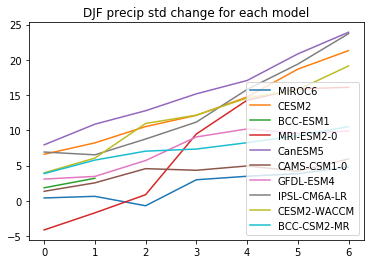

In [90]:
plt.plot((dsdG_djf_np-1)*100)
plt.title('DJF precip std change for each model')
plt.legend(modelnames)

Text(0, 0.5, 'Precip change (%)')

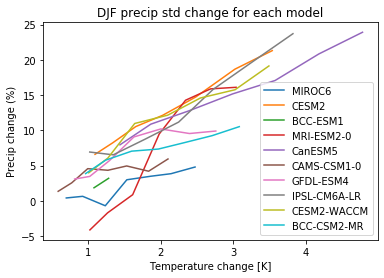

In [94]:
plt.plot(dt,(dsdG_djf_np-1)*100)
plt.title('DJF precip std change for each model')
plt.legend(modelnames)
plt.xlabel('Temperature change [K]')
plt.ylabel('Precip change (%)')


# Needed: get rid of models with NaNs before taking the multi-model mean

In [104]:
for i in range(10):
    print(modelnames[i])
    print(dt[:,i])
    print(dsdG_djf_np[:,i])
    print

MIROC6
[0.69760358 0.92414077 1.23591328 1.53334468 1.86146229 2.14341351
 2.47539063]
[1.00410916 1.00642759 0.99304771 1.02991738 1.03489617 1.03853684
 1.04800955]
CESM2
[1.0943906  1.33759377 1.65694182 2.02734797 2.48502429 3.02513154
 3.54099501]
[1.06604557 1.08227811 1.10538793 1.12134327 1.14736634 1.18681991
 1.21315694]
BCC-ESM1
[1.08017615 1.28208879        nan        nan        nan        nan
        nan]
[1.01855125 1.03201613        nan        nan        nan        nan
        nan]
MRI-ESM2-0
[1.02391869 1.26783705 1.61427509 1.98043718 2.34385808 2.68977643
 3.04222358]
[0.95877213 0.98300485 1.00873414 1.09488765 1.14275303 1.1588908
 1.16111286]
CanESM5
[1.43862323 1.86378497 2.39486586 2.99647037 3.57941802 4.18496177
 4.7870368 ]
[1.07952093 1.10878608 1.12788947 1.1518364  1.17073651 1.20848359
 1.23922087]
CAMS-CSM1-0
[0.58557645 0.77298177 0.99394305 1.27233195 1.53131223 1.83411814
 2.10157417]
[1.01353749 1.02556207 1.04568893 1.04339748 1.04951387 1.04204886
 

In [107]:
np.nanmean(dt,axis=1)

array([0.97267111, 1.23293357, 1.5803027 , 1.97306415, 2.37773672,
       2.80401369, 3.23506764])

In [111]:
np.nanmean((dsdG_djf_np-1)*100,axis=1)

array([ 3.19218341,  4.56547535,  6.73334441,  9.3212659 , 11.4861159 ,
       13.0496287 , 15.04240273])

Text(0, 0.5, 'Precip change (%)')

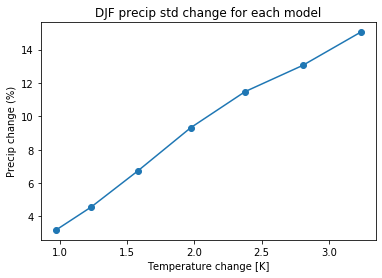

In [113]:
plt.plot(np.nanmean(dt,axis=1),np.nanmean((dsdG_djf_np-1)*100,axis=1),marker='o')
plt.title('DJF precip std change for each model')
plt.xlabel('Temperature change [K]')
plt.ylabel('Precip change (%)')